In [176]:
!pip install transformers sentencepiece

In [177]:
import requests
import json
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from numpy import dot
from numpy.linalg import norm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

THRESHOLD = 0.55
API_ID = 2

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
dataset_url = 'https://raw.githubusercontent.com/tangqiaoyu/ToolAlpaca/refs/heads/main/data/train_data.json'
response = requests.get(dataset_url)
data = json.loads(response.text)

In [179]:
def str2dict(s):
    '''
    Dictionary parsing from ToolAlpaca
    '''
    s = s[s.find('{"')+2:s.rfind('"}')]
    s = s.split('.", ')
    d = dict()
    for param in s:
        key, value = param.split('": "')
        key = key.replace('"', '')
        value = value.replace('"', '')
        d[key] = value
    return d

def get_funcs(funcs_desc):
    '''
    Extract functions from ToolAlpaca, including their descriptions and parameters.
    '''
    funcs_preprocessed = dict()
    for func_name, description in funcs_desc.items():
        params = dict()
        output = ''
        sequences = description.split('\n')
        for seq in sequences:
            if 'Parameters: ' in seq and '{}' not in seq:
                params = str2dict(seq.replace('Parameters: ', ''))
            if 'Output: ' in seq:
                output = seq.replace('Output: ', '')
        if len(params) > 0 or len(output) > 0:
            funcs_preprocessed[func_name] = {
                'Parameters': params,
                'Output': output
            }
    return funcs_preprocessed

In [180]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embeddings(params, output):
    '''
    Extract embedding from parameter and output descriptions.
    '''
    sentences = params + [output]
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings[:-1], sentence_embeddings[-1]

def encode_funcs(funcs_preprocessed):
    '''
    Applies get_embeddings function to dictionary from get_funcs function.
    '''
    all_params_encoded, all_outputs_encoded = [], []
    for func, data in funcs_preprocessed.items():
        params = []
        for param, desc in data['Parameters'].items():
            text = '. '.join([param, desc])
            params.append(text)
        output = data['Output']
        params_encoded, output_encoded = get_embeddings(params, output)
        all_params_encoded.append(params_encoded)
        all_outputs_encoded.append(output_encoded)
    return all_params_encoded, all_outputs_encoded

def get_cosine_similarity(emb1, emb2):
    cos_sim = dot(emb1, emb2)/(norm(emb1)*norm(emb2))
    return cos_sim

def get_bonds(all_params_encoded, all_outputs_encoded):
    '''
    Calculates cosine proximity between all extracted embeddings.
    Generates a list of edges depending on THRESHOLD.
    This list contains only function and parameter IDs.
    '''
    bonds = [] # [[input_func_id, output_func_id, input_param_id, cos_sim], ...]
    for input_func_id in range(len(all_outputs_encoded)):
        for param_id in range(len(all_params_encoded[input_func_id])):
            for output_func_id in range(len(all_outputs_encoded)):
                if output_func_id != input_func_id:
                    cosine_similarity = get_cosine_similarity(
                        all_params_encoded[input_func_id][param_id],
                        all_outputs_encoded[output_func_id])
                    if cosine_similarity > THRESHOLD:
                        bonds.append([input_func_id, output_func_id, param_id, cosine_similarity])
    return bonds

def decode_bonds(bonds, funcs_preprocessed):
    '''
    Decodes function and parameter IDs from get_bonds dunction into their names.
    '''
    func_names, params_names = [], []
    for func, data in funcs_preprocessed.items():
        params = [param for param in data['Parameters'].keys()]
        params_names.append(params)
        func_names.append(func)
    bonds_encoded = []
    for bond in bonds:
        bonds_encoded.append([
            func_names[bond[0]],
            func_names[bond[1]],
            params_names[bond[0]][bond[2]],
            bond[3]
        ])
    return bonds_encoded

In [194]:
funcs = get_funcs(data[API_ID]['Function_Description'])
params, outputs = encode_funcs(funcs)
bonds = get_bonds(params, outputs)
decoded_bonds = decode_bonds(bonds, funcs)
df = pd.DataFrame(decoded_bonds, columns=['input_func', 'output_func', 'input_param', 'cos_sim'])
df.sort_values('cos_sim', ascending=False, ignore_index=True)

,input_func,output_func,input_param,cos_sim
0,getQuotesByTag,getTags,tag,0.800620
1,searchQuotes,getTags,query,0.702165
2,searchQuotes,getQuotesByTag,query,0.611494
3,getQuoteById,getQuotesByTag,id,0.610799
4,getQuoteById,searchQuotes,id,0.598815
5,getQuoteById,getTags,id,0.570744


In [195]:
funcs

{'getRandomQuote': {'Parameters': {},
  'Output': 'A random quote or tweet attributed to Donald Trump, including its ID, date, and source.'},
 'searchQuotes': {'Parameters': {'query': 'Required. string. The keyword(s) to search for in the quotes and tweets',
   'page': 'integer. The page number of the search results',
   'size': 'integer. The number of results per page.'},
  'Output': 'A list of quotes or tweets containing the specified keywords, including their IDs, dates, and sources. Pagination information will also be provided.'},
 'getQuoteById': {'Parameters': {'id': 'Required. string. The ID number of the quote or tweet to retrieve.'},
  'Output': 'The quote or tweet with the specified ID, including its date and source.'},
 'getTags': {'Parameters': {},
  'Output': 'A list of tags that can be used to filter quotes and tweets.'},
 'getQuotesByTag': {'Parameters': {'tag': 'Required. string. The tag to filter quotes and tweets by',
   'page': 'integer. The page number of the search

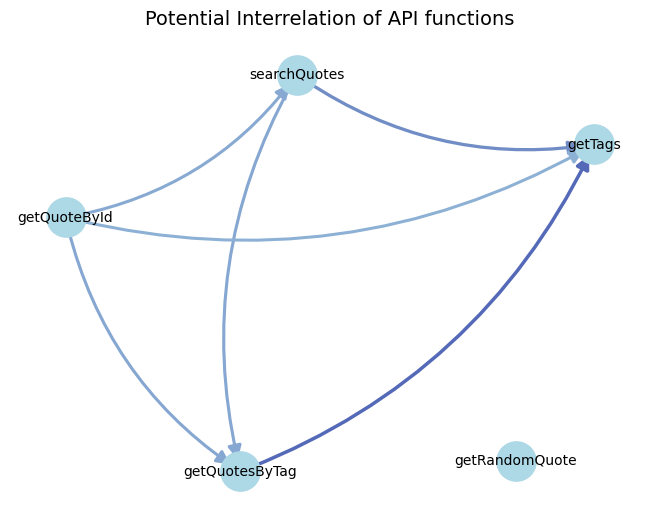

In [203]:
import networkx as nx
import matplotlib.pyplot as plt


def create_weighted_directed_graph(edges, nodes):
    graph = nx.DiGraph()
    graph.add_nodes_from(nodes)

    for edge in edges:
        source, target, _, weight = edge
        graph.add_edge(source, target, weight=weight)

    return graph

def gradient_color(t):
    light_blue = (173 / 255, 216 / 255, 230 / 255)  # RGB for light blue
    dark_blue = (0, 0, 139 / 255)                   # RGB for dark blue

    r = light_blue[0] * (1 - t) + dark_blue[0] * t
    g = light_blue[1] * (1 - t) + dark_blue[1] * t
    b = light_blue[2] * (1 - t) + dark_blue[2] * t

    return (r, g, b)

def draw_graph(graph):
    pos = nx.spring_layout(graph, k=1.5)
    edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
    edge_colors = [gradient_color(weight**3) for weight in edge_weights] # Exponentiation for better contrast on the graph
    edge_widths = [2 + (weight**3) for weight in edge_weights]
    nx.draw(graph, pos, with_labels=True, node_size=800, node_color='lightblue', font_size=10)
    nx.draw_networkx_edges(graph, pos,
                             edge_color='white',  # White color to hide default straight edges
                             connectionstyle='arc3,rad=0.0',
                             arrows=True,
                             arrowstyle='-|>',
                             arrowsize=20,
                             width=4)

    nx.draw_networkx_edges(graph, pos,
                             edge_color=edge_colors,
                             width=edge_widths,
                             connectionstyle='arc3,rad=0.2',
                             arrows=True,
                             arrowstyle='-|>',
                             arrowsize=20)

    plt.title('Potential Interrelation of API functions', fontsize=14)
    plt.axis('off')
    plt.show()

weighted_graph = create_weighted_directed_graph(decoded_bonds, list(funcs.keys()))
draw_graph(weighted_graph)